In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
from sklearn.neighbors import NearestNeighbors

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/My Drive/treatment_control_data.csv'

data = pd.read_csv(path, index_col='id')

In [ ]:
# Посмотрю шапку датафрейма

data.head()

,balance,gender,region,age,date,T_marker
id,,,,,,
13937,139345.86,Female,Moscow,48,2022-06-30,0
32065,17772.47,Male,Moscow,43,2022-06-30,0
86812,154122.51,Male,Moscow,41,2022-05-31,0
127144,179735.64,Male,Saint_Petersburg,41,2022-08-31,0
51583,35974.55,Male,Nizhniy_Novgorod,41,2022-08-31,0


In [ ]:
# Посмотрю информацию по типам данных

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 920000 entries, 13937 to 28890
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   balance   920000 non-null  float64
 1   gender    920000 non-null  object 
 2   region    920000 non-null  object 
 3   age       920000 non-null  int64  
 4   date      920000 non-null  object 
 5   T_marker  920000 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 49.1+ MB


In [ ]:
# Посмотрю уникальные значения в столбце region

for i in data.columns:
    print(data[i].unique())

[139345.86  17772.47 154122.51 ...  36844.22  25419.57  16607.48]
['Female' 'Male']
['Moscow' 'Saint_Petersburg' 'Nizhniy_Novgorod']
[48 43 41 44 49 54 37 45 35 42 47 40 46 53 39 56 51 58 38 34 52 50 33 32
 36 55 28 30 29 31 57 26 27 59 60 24 25 61 62 22 23 63 64 20 65 21 18 19]
['2022-06-30' '2022-05-31' '2022-08-31' '2022-07-31']
[0 1]


In [ ]:
# Проверю наличие пропусков

data.isna().sum()

,0
balance,0
gender,0
region,0
age,0
date,0
T_marker,0


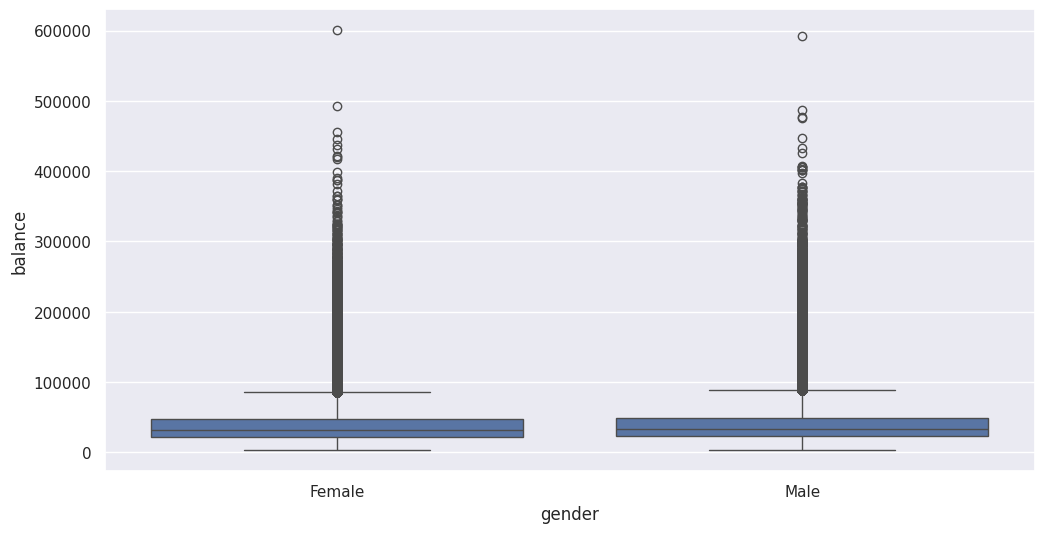

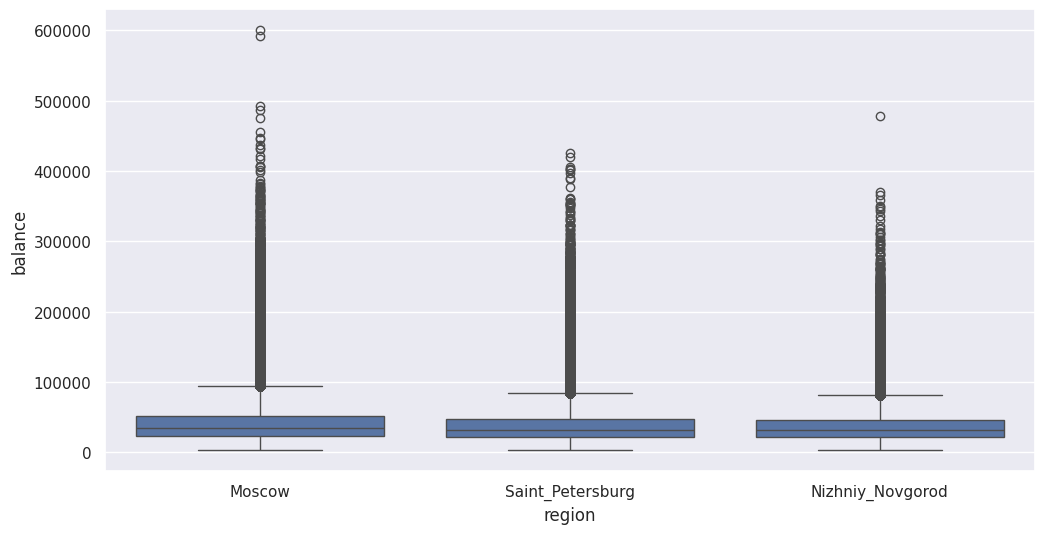

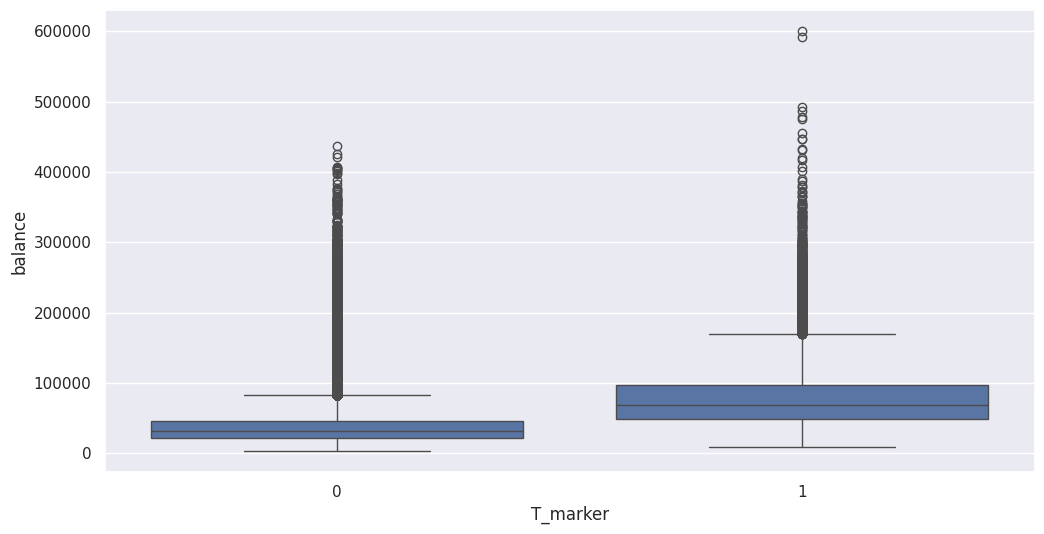

In [ ]:
# Построю график "ящик с усами" для просмотра выбросов по балансу

def plot_balance(col_name):
    plt.figure(figsize=(12, 6))

    sns.boxplot(x=data[col_name], y=data.balance)

    return plt.show()


plot_balance('gender')
plot_balance('region')
plot_balance('T_marker')

In [ ]:
# На графиках видно выбросы в основном больше 450000 тысяч, обработаю эти значения

median_value = data.balance.median()

data.loc[data['balance'] >= 450000, 'balance'] = median_value

In [ ]:
# Переведу столбец с датой в тип дейттайм, чтобы отследить изменения в целевой группе

data.date = pd.to_datetime(data.date)

In [ ]:
# Сортирую массив по дате, так как изменения в целевой группе вступили в силу в августе и сортировка позволит увидеть эти изменения

data_sorted = data.sort_values(by='date')

<Axes: xlabel='date', ylabel='balance'>

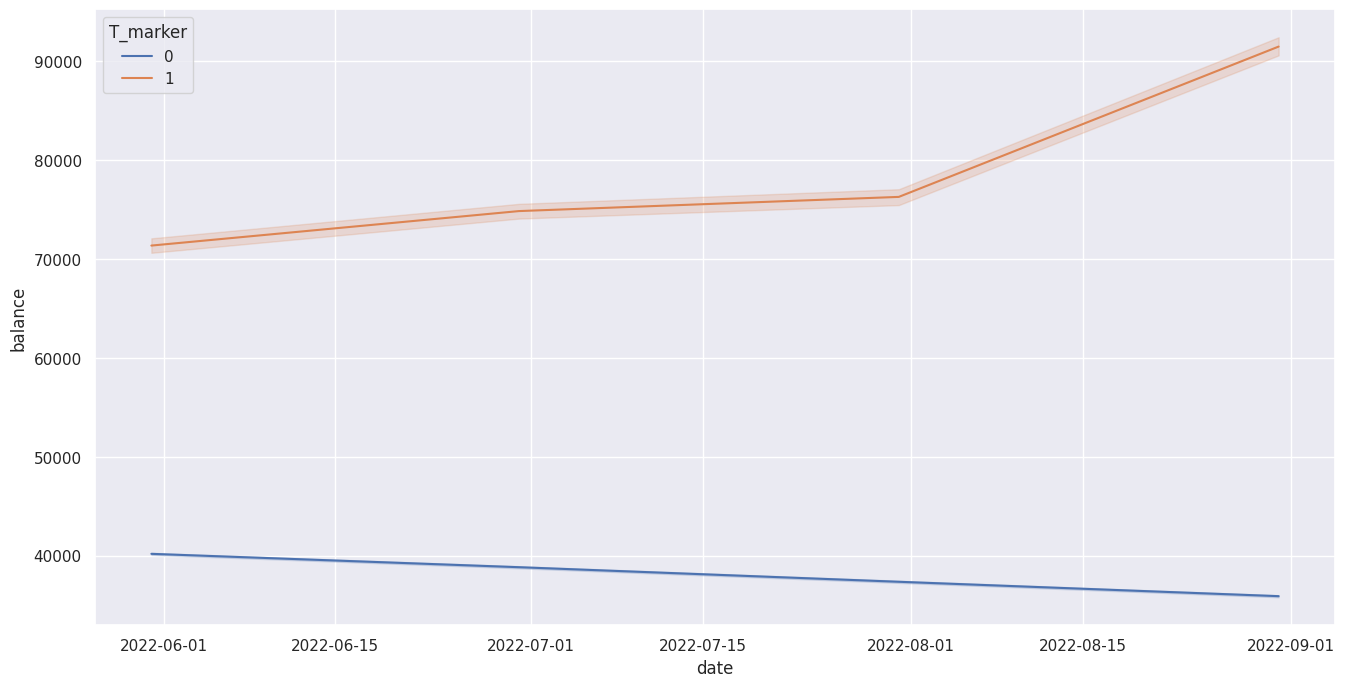

In [ ]:
# Построю предварительный график, чтобы увидеть изменения наглядно

plt.figure(figsize=(16, 8))

sns.lineplot(x=data_sorted.date, y=data_sorted.balance, hue=data_sorted.T_marker)

In [ ]:
# По графику четко видно изменения
# Разделю группы на целевую и контрольную по столбцу маркера

treatment_group = data_sorted[data_sorted['T_marker'] == 1]
control_group = data_sorted[data_sorted['T_marker'] == 0]

In [ ]:
# Начну подбирать контрольную группу для оценки дополнительного дохода, для этого я выберу алгоритм ближайших соседей

# Опишу независимые переменные

X_treatment = treatment_group.drop(columns='date')
X_control = control_group.drop(columns='date')

In [ ]:
# Преобразую категориальные переменные в числовые

X_treatment = pd.get_dummies(X_treatment)
X_control = pd.get_dummies(X_control)

In [ ]:
# Опишу модель и объявлю новый датафрейм для матчинга

model = NearestNeighbors(n_neighbors=1).fit(X_control)
distances, indices = model.kneighbors(X_treatment)
matched_control_group = control_group.iloc[indices.flatten()]

In [ ]:
# Выделю контрольную группу в 40000 участников

matched_control_group = matched_control_group.sample(n=40000)

print("Целевая группа:")
print(treatment_group.describe())
print("\nПодобранная контрольная группа:")
print(matched_control_group.describe())

Целевая группа:
             balance          age                 date  T_marker
count   40000.000000  40000.00000                40000   40000.0
mean    78466.786741     39.53000  2022-07-15 18:00:00       1.0
min      8683.360000     19.00000  2022-05-31 00:00:00       1.0
25%     48701.727500     36.00000  2022-06-22 12:00:00       1.0
50%     68920.795000     40.00000  2022-07-15 12:00:00       1.0
75%     97219.845000     43.00000  2022-08-07 18:00:00       1.0
max    446748.400000     61.00000  2022-08-31 00:00:00       1.0
std     42732.926146      5.02073                  NaN       0.0

Подобранная контрольная группа:
             balance           age                           date  T_marker
count   40000.000000  40000.000000                          40000   40000.0
mean    78466.446791     39.890625  2022-07-13 08:10:27.839999744       0.0
min      8683.620000     23.000000            2022-05-31 00:00:00       0.0
25%     48701.635000     37.000000            2022-05-31 00:00

In [ ]:
# Выбор был сделан на основе алгоритма ближайших соседей, так как он отлично находит и описывает похожие на источник данные

# Так же через метод describe я могу убедиться в своих расчетах, так как по балансу и возрасту видно практически идеальную схожесть целевой и контрольной группы

Text(0, 0.5, 'Баланс')

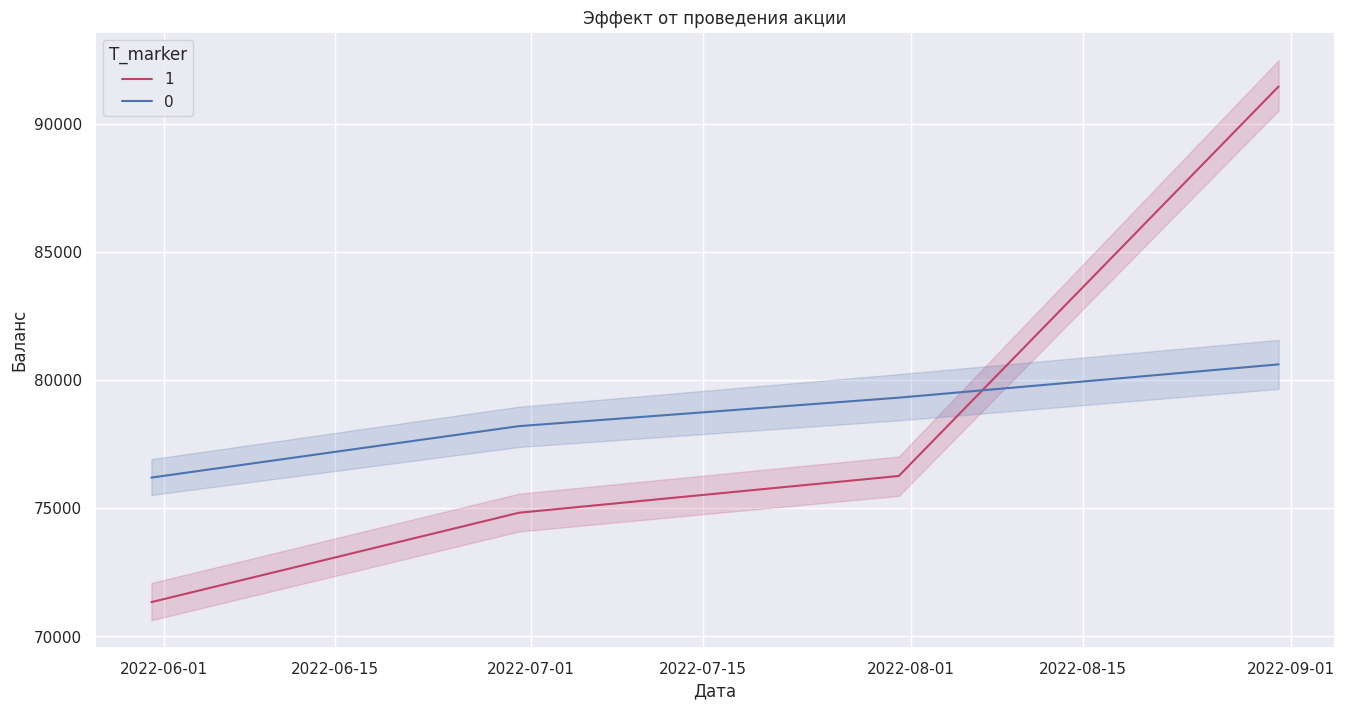

In [ ]:
# Построю линейный график для наглядности изменений и видимости эффекта от проведения акции

plt.figure(figsize=(16, 8))

sns.lineplot(x=treatment_group.date, y=treatment_group.balance, hue=treatment_group.T_marker, palette='flare')

sns.lineplot(x=matched_control_group.date, y=matched_control_group.balance, hue=matched_control_group.T_marker)

plt.title('Эффект от проведения акции')
plt.xlabel('Дата')
plt.ylabel('Баланс')

In [ ]:
# На графике видно, что целевая и контрольные группы идут рядом друг с другом, а в августе 2022 года резко начинаются изменения в целевой группе, отсюда мы можем посчтитать эффект от проведенной акции с помощью метода difference in difference

In [ ]:
# Опишу в переменных стартовые и конечные даты до и после акции

start_date_after = '2022-08-01'
end_date_after = '2022-09-01'
start_date_before = '2022-05-31'
end_date_before = '2022-08-01'

In [ ]:
# Рассчитаю эффект от проведения акции по формуле
# эффект = ((среднее значение баланса в целевой группе после акции - среднее значение баланса в целевой группе до акции) - (среднее значение баланса в контрольной группе после акции - среднее значение баланса в контрольной группе до акции)) * количество участников в целевой группе

In [ ]:
# Укажу периоды

periods = {
    'before': (start_date_before, end_date_before),
    'after': (start_date_after, end_date_after)
}

In [ ]:
# Напишу функции для получения средних по группе и периоду

def get_mean_balance(df, period):
    start, end = periods[period]
    return df[(df['date'] >= start) & (df['date'] <= end)]['balance'].mean()

In [ ]:
# Рассчитаю эффекта

effect = (
    get_mean_balance(treatment_group, 'after') - get_mean_balance(treatment_group, 'before')
) - (
    get_mean_balance(matched_control_group, 'after') - get_mean_balance(matched_control_group, 'before')
)

effect *= 40000

print(f"Дополнительная прибыль: {effect:,.2f} рублей")

Дополнительная прибыль: 581,342,426.89 рублей


Построю графики для результатов

In [ ]:
# Рассчитаю средний баланс для каждой группы и периода

mean_before_treatment = get_mean_balance(treatment_group, 'before')
mean_after_treatment = get_mean_balance(treatment_group, 'after')
mean_before_control = get_mean_balance(matched_control_group, 'before')
mean_after_control = get_mean_balance(matched_control_group, 'after')

In [ ]:
# Подготовлю данные для графика

groups = [
    'Контроль (до)', 'Контроль (после)', 'Целевая (до)', 'Целевая (после)'
    ]

values = [mean_before_control, mean_after_control, mean_before_treatment, mean_after_treatment]

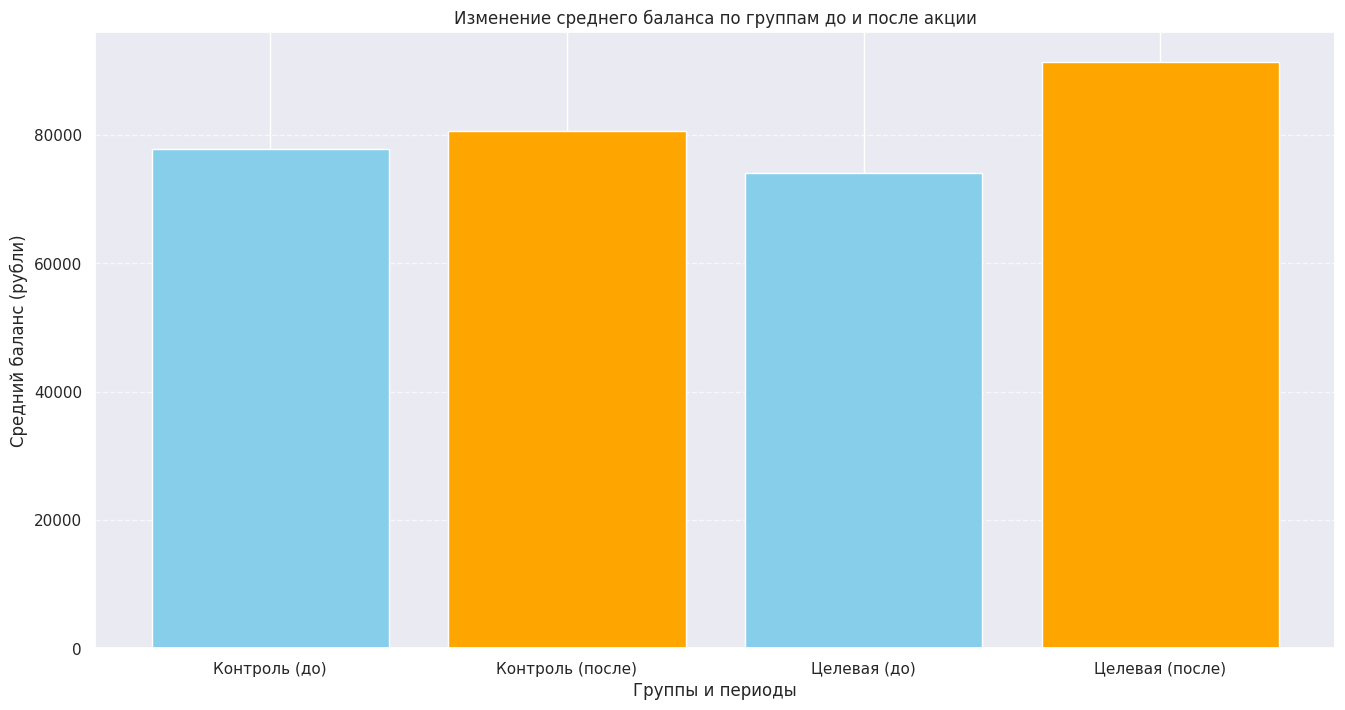

In [ ]:
# Построю гистограмму для наглядного отображения эффекта

plt.figure(figsize=(16, 8))

plt.bar(groups, values, color=['skyblue', 'orange', 'skyblue', 'orange'])
plt.title('Изменение среднего баланса по группам до и после акции')
plt.ylabel('Средний баланс (рубли)')
plt.xlabel('Группы и периоды')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [ ]:
# Подготовлю данные: группирую по дате и считаю средний баланс

def get_daily_mean(df):
    return df.groupby('date')['balance'].mean()

In [ ]:
# Получу среднее за каждый день

treatment_daily = get_daily_mean(treatment_group)
control_daily = get_daily_mean(matched_control_group)

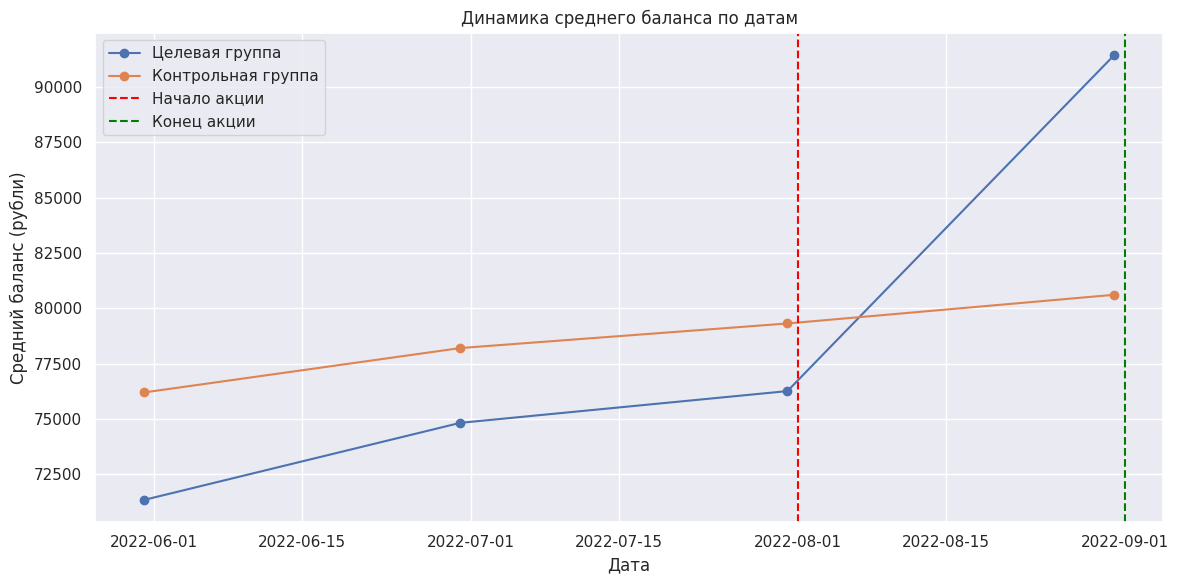

In [ ]:
# Построю график временного ряда

plt.figure(figsize=(12,6))
plt.plot(treatment_daily.index, treatment_daily.values, label='Целевая группа', marker='o')
plt.plot(control_daily.index, control_daily.values, label='Контрольная группа', marker='o')

# Добавлю шкалу (начиная с периода до акции и после)

plt.axvline(pd.to_datetime(start_date_after), color='red', linestyle='--', label='Начало акции')
plt.axvline(pd.to_datetime(end_date_after), color='green', linestyle='--', label='Конец акции')

plt.title('Динамика среднего баланса по датам')
plt.xlabel('Дата')
plt.ylabel('Средний баланс (рубли)')
plt.legend()

plt.tight_layout()
plt.show()